
Задачу поставлю такую - натренировать классификатор по опознанию типа велосипеда на небольшом датасете фото из публичных источников.

Дату пронализирую, напишу report что получилось

# Data

In [ ]:
! wget http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip

--2024-12-02 19:16:46--  http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip
Resolving fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)... 212.24.105.216
Connecting to fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)|212.24.105.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110280897 (105M) [application/zip]
Saving to: ‘bt_dataset3.zip’

bt_dataset3.zip     100%[===================>] 105.17M  7.81MB/s    in 23s     

2024-12-02 19:17:09 (4.60 MB/s) - ‘bt_dataset3.zip’ saved [110280897/110280897]



In [ ]:
! unzip bt_dataset3.zip

Archive:  bt_dataset3.zip
   creating: bike/
   creating: bike/bike_type/
   creating: bike/bike_type/train/
   creating: bike/bike_type/train/road/
  inflating: bike/bike_type/train/road/road_4884_5fccd8907cba8.jpeg  
  inflating: bike/bike_type/train/road/road_2553_5fccd83752957.jpeg  
  inflating: bike/bike_type/train/road/road_87_5fccd85402f10.jpeg  
  inflating: bike/bike_type/train/road/road_2457_5fccd81a0919f.jpeg  
  inflating: bike/bike_type/train/road/road_3543_5fccd81d36d22.jpeg  
  inflating: bike/bike_type/train/road/road_85_5fccd8080cc2e.jpeg  
  inflating: bike/bike_type/train/road/road_2515_5fccd8591c9fa.jpeg  
  inflating: bike/bike_type/train/road/road_1965_5fccd81e7e8a4.jpeg  
  inflating: bike/bike_type/train/road/road_2663_5fccd892cdad1.jpeg  
  inflating: bike/bike_type/train/road/road_2297_5fccd83b36a41.jpeg  
  inflating: bike/bike_type/train/road/road_2115_5fccd82b972c0.jpeg  
  inflating: bike/bike_type/train/road/road_2852_5fccd80ab6871.jpeg  
  inflating: bi

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


Карпов Михаил Дмитриевич

In [ ]:
import os
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt

# Путь к обучающим данным
data_path = "bike/bike_type/train"

# Функция для анализа данных
def analyze_data(data_path):
    categories = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith((".jpeg", ".jpg", ".png")):  # Проверяем только изображения
                category = os.path.basename(root)  # Имя категории — это имя папки
                categories.append(category)
    return Counter(categories)

# Анализируем данные
category_counts = analyze_data(data_path)
print("Количество изображений в каждой категории:")
for category, count in category_counts.items():
    print(f"{category}: {count}")

# Сначала писал код чтобы сделать визуализацию данных, но потом заглянул в папку и увидел,
# что там всего 5 категорий: так что можем ограничиться просмотром изображений.




Количество изображений в каждой категории:
road: 336
mtb: 1016
city: 714
child: 115
bmx: 109


#Имбаланс
Налицо имбаланс классов. А еще по разному фотографировали: есть небольшой процент сделанных фото с неплохим качеством, и есть много фото взятых из стока с плохим качеством; или, возможно, вырезанных кусков фотографий (зато какая никакая нормализация - велосипеды все по центру).

Попробуем решить проблему имбаланса аугментациями классов с малым количеством данных: road, bmx, child

In [ ]:
import os
from PIL import Image
from torchvision import transforms
from tqdm import tqdm  # Для отображения прогресса

def augment_images(data_path, target_classes, target_count):
    """
    Аугментирует данные для указанных классов, чтобы довести количество изображений до target_count.

    Parameters:
    - data_path: путь к данным (папке train или val).
    - target_classes: список категорий для аугментации.
    - target_count: минимальное количество изображений, которое нужно достичь.
    """
    augmentation = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
    ])

    for category in target_classes:
        category_path = os.path.join(data_path, category)
        images = [os.path.join(category_path, img) for img in os.listdir(category_path) if img.endswith((".jpeg", ".jpg", ".png"))]

        current_count = len(images)
        if current_count >= target_count:
            print(f"Категория '{category}' уже имеет {current_count} изображений, аугментация не требуется.")
            continue

        print(f"Аугментация для категории '{category}', текущих изображений: {current_count}")
        while len(images) < target_count:
            for img_path in tqdm(images, desc=f"Processing {category}"):
                if len(images) >= target_count:
                    break

                # Открываем изображение
                img = Image.open(img_path)

                # Применяем аугментацию
                augmented_img = augmentation(img)

                # Сохраняем новое изображение
                new_filename = os.path.join(category_path, f"aug_{len(images)}.jpg")
                augmented_img.save(new_filename)
                images.append(new_filename)

# Указываем путь к данным и параметры аугментации
train_data_path = "bike/bike_type/train"
target_classes = ["road", "bmx", "child"]  # Классы для аугментации
target_count = 500  # Целевое количество изображений

# Запускаем аугментацию
augment_images(train_data_path, target_classes, target_count)

Аугментация для категории 'road', текущих изображений: 336


Processing road:  49%|████▉     | 164/336 [00:01<00:01, 121.10it/s]


Аугментация для категории 'bmx', текущих изображений: 109


Processing bmx: 391it [00:01, 286.18it/s]


Аугментация для категории 'child', текущих изображений: 115


Processing child: 385it [00:02, 132.33it/s]


#Модель
Попробую дообучить модель из torchvision.models. А потом сравним с моей самописной моделью.

Edit: друг отсоветовал, самописную использовать не будем.


Device: cuda
Epoch 1/10
----------


100%|██████████| 15/15 [00:01<00:00,  7.82it/s]


Train Loss: 0.8124, Train Acc: 69.16%
Val Loss: 0.6485, Val Acc: 79.39%

Epoch 2/10
----------


100%|██████████| 15/15 [00:01<00:00,  7.89it/s]


Train Loss: 0.4185, Train Acc: 83.90%
Val Loss: 0.7505, Val Acc: 81.56%

Epoch 3/10
----------


100%|██████████| 15/15 [00:02<00:00,  6.05it/s]


Train Loss: 0.3021, Train Acc: 88.98%
Val Loss: 1.0677, Val Acc: 70.93%

Epoch 4/10
----------


100%|██████████| 15/15 [00:01<00:00,  7.80it/s]


Train Loss: 0.2304, Train Acc: 91.64%
Val Loss: 1.0351, Val Acc: 80.48%

Epoch 5/10
----------


100%|██████████| 15/15 [00:01<00:00,  7.78it/s]


Train Loss: 0.1688, Train Acc: 94.30%
Val Loss: 0.9661, Val Acc: 75.70%

Epoch 6/10
----------


100%|██████████| 15/15 [00:01<00:00,  7.70it/s]


Train Loss: 0.2004, Train Acc: 92.76%
Val Loss: 0.8755, Val Acc: 81.56%

Epoch 7/10
----------


100%|██████████| 15/15 [00:02<00:00,  6.83it/s]


Train Loss: 0.1584, Train Acc: 94.95%
Val Loss: 0.9327, Val Acc: 81.78%

Epoch 8/10
----------


100%|██████████| 15/15 [00:01<00:00,  7.82it/s]


Train Loss: 0.1243, Train Acc: 95.45%
Val Loss: 1.2326, Val Acc: 78.52%

Epoch 9/10
----------


100%|██████████| 15/15 [00:01<00:00,  7.78it/s]


Train Loss: 0.1199, Train Acc: 95.85%
Val Loss: 1.0561, Val Acc: 78.09%

Epoch 10/10
----------


100%|██████████| 15/15 [00:02<00:00,  7.04it/s]


Train Loss: 0.1208, Train Acc: 95.88%
Val Loss: 1.3500, Val Acc: 77.01%



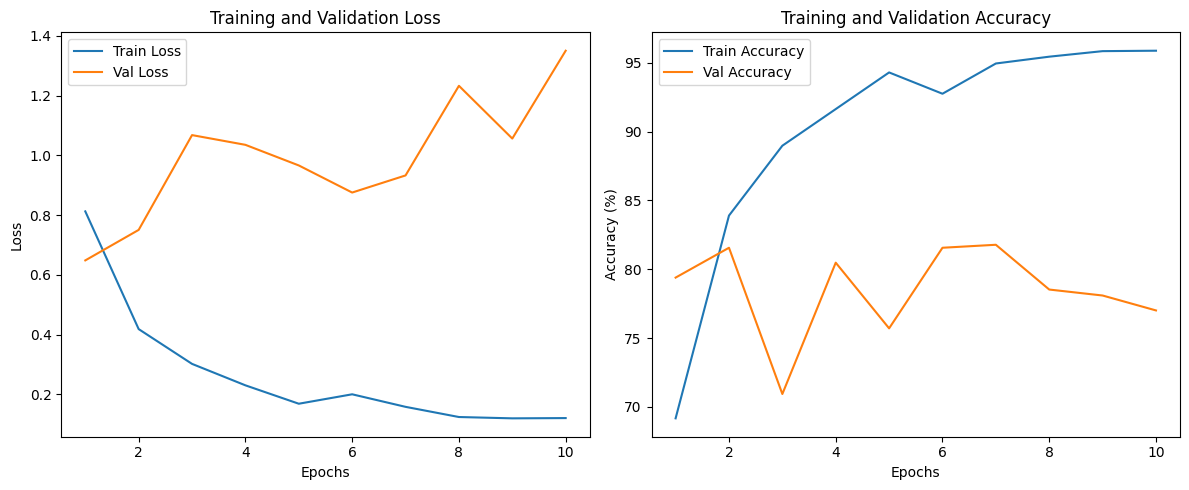

In [ ]:
import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt  # Добавлено для визуализации

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# 1. Загрузка предобученной модели ResNet18
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

# Меняем последний слой под нашу задачу (5 классов: bmx, child, city, mtb, road)
num_classes = 5
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Переносим модель на GPU
model = model.to(device)

# 2. Готовим данные с дополнительными аугментациями
image_size = (224, 224)

train_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(image_size[0], scale=(0.8, 1.0)),  # Случайный обрезок
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Сдвиг и вращение
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Кастомный класс Dataset
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.files = []
        for cls in self.classes:
            cls_dir = os.path.join(data_dir, cls)
            self.files.extend([(os.path.join(cls_dir, file), cls) for file in os.listdir(cls_dir) if file.endswith((".jpeg", ".jpg", ".png"))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path, cls = self.files[idx]
        image = Image.open(file_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.class_to_idx[cls]
        return image, label

# Создаем датасеты и даталоадеры
train_dir = "bike/bike_type/train"
val_dir = "bike/bike_type/val"

train_dataset = CustomDataset(train_dir, train_transforms)
val_dataset = CustomDataset(val_dir, val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 4. Настроим обучение
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# 5. Тренировка модели
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10):
    # Для хранения метрик
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Обучение
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100.0 * correct / total
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)

        # Валидация
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100.0 * correct / total
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        print()

    # Визуализация метрик
    plot_metrics(history)

def plot_metrics(history):
    """ Функция для визуализации метрик """
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_accuracy"], label="Train Accuracy")
    plt.plot(epochs, history["val_accuracy"], label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Запуск
train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10)

Графики получились грустными. Переобучение начиная со второй эпохи. Посмотрим что будет с метриками F1, Precision и Recall. А еще внесем в код изменения: например шедулер и раннее завершение

In [ ]:
!nvidia-smi

Mon Dec  2 19:12:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Обновленная функция тренировки с метриками F1, Precision и Recall

def train_model_with_metrics(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10):
    best_val_loss = float('inf')
    no_improvement_counter = 0  # Счётчик для ранней остановки

    # Шедулер для уменьшения скорости обучения
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Обучение
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100.0 * correct / total
        train_f1 = f1_score(all_labels, all_predictions, average='weighted')
        train_precision = precision_score(all_labels, all_predictions, average='weighted')
        train_recall = recall_score(all_labels, all_predictions, average='weighted')

        # Валидация
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_accuracy = 100.0 * correct / total
        val_f1 = f1_score(all_labels, all_predictions, average='weighted')
        val_precision = precision_score(all_labels, all_predictions, average='weighted')
        val_recall = recall_score(all_labels, all_predictions, average='weighted')

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")
        print()

        # Используем шедулер для уменьшения скорости обучения
        scheduler.step(val_loss)

        # Ранняя остановка
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= 3:
            print("Early stopping triggered")
            break

# Запускаем обучение с новыми метриками
train_model_with_metrics(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10)

Epoch 1/10
----------


100%|██████████| 15/15 [00:01<00:00,  7.86it/s]


Train Loss: 0.1391, Train Acc: 95.36%, Train F1: 0.9536, Train Precision: 0.9536, Train Recall: 0.9536
Val Loss: 1.0519, Val Acc: 76.79%, Val F1: 0.7617, Val Precision: 0.7754, Val Recall: 0.7679

Epoch 2/10
----------


100%|██████████| 15/15 [00:01<00:00,  7.77it/s]


Train Loss: 0.1264, Train Acc: 95.76%, Train F1: 0.9576, Train Precision: 0.9575, Train Recall: 0.9576
Val Loss: 1.5079, Val Acc: 80.04%, Val F1: 0.7861, Val Precision: 0.8331, Val Recall: 0.8004

Epoch 3/10
----------


100%|██████████| 15/15 [00:01<00:00,  7.78it/s]


Train Loss: 0.1240, Train Acc: 95.63%, Train F1: 0.9563, Train Precision: 0.9564, Train Recall: 0.9563
Val Loss: 1.2285, Val Acc: 71.37%, Val F1: 0.7100, Val Precision: 0.7232, Val Recall: 0.7137

Epoch 4/10
----------


100%|██████████| 15/15 [00:02<00:00,  7.27it/s]

Train Loss: 0.1246, Train Acc: 96.10%, Train F1: 0.9610, Train Precision: 0.9611, Train Recall: 0.9610
Val Loss: 1.1443, Val Acc: 79.39%, Val F1: 0.7999, Val Precision: 0.8273, Val Recall: 0.7939

Early stopping triggered


# Report
Задачe перед собой ставил обучить **модель классификации изображений по 5 классам** велосипедов.

С данными были некоторые проблемы: неравномерное распределение классов и малое количество изображений child, bmx, road (решил добором большим количеством аугментаций), разное качество изображений (отчасти поправил приведением всех картинок к единому разрешению, но предполагаю это не результативный подход). А еще засветы, странные ракурсы и пр., буду считать их за "первичные" аугментации.

При обучении, как предупредили, сразу столкнулся с переобучением, изменение обучения модели не помогло. Возможно стоило использовать модель с менее сложной архитектурой - например вместо resnet-а mobilenet. Шедулер не особо помог, почти сразу остановили обучение, так как лосс не падал.

Результаты на train-е, хорошие, есть подозрение что модель достаточно мощная и просто выучила картинки, потому что на val-е переобучение идет уже с первой-второй эпохи.